In [1]:
import pandas as pd

# Load the dataset from the CSV file
df = pd.read_csv("../data/water_quality.csv")

# Display the first few rows to ensure it's loaded correctly
print(df.head())


    pH  Temperature  Dissolved Oxygen  Electrical Conductivity  Turbidity  \
0  5.3           24               6.7                      2.0        1.9   
1  5.4           24               4.1                      3.1        2.0   
2  7.4           18               8.4                      1.9        0.6   
3  5.8           23               5.0                      3.0        1.8   
4  6.9           15               6.7                      3.2        1.7   

   Nitrogen  Phosphorus  Potassium  Water Hardness  Label  
0        17           6         19             110      1  
1        12           2         17              42      0  
2         5           6         24              63      1  
3         6           4         22              85      0  
4        13           6         15              70      1  


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Fill missing values (if any)
df.fillna(df.median(), inplace=True)  # Using median for numerical columns

# Encode the target variable 'Label' if it's categorical
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into features (X) and target (y)
X = df.drop('Label', axis=1)  # Features (all columns except 'Label')
y = df['Label']  # Target (Label)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 8800
Test set size: 2200


In [3]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rfc.fit(X_train, y_train)

# Predict on the test set
y_pred = rfc.predict(X_test)

# Print model performance
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


Accuracy: 0.5427
AUC-ROC: 0.5777


In [4]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[582 443]
 [563 612]]


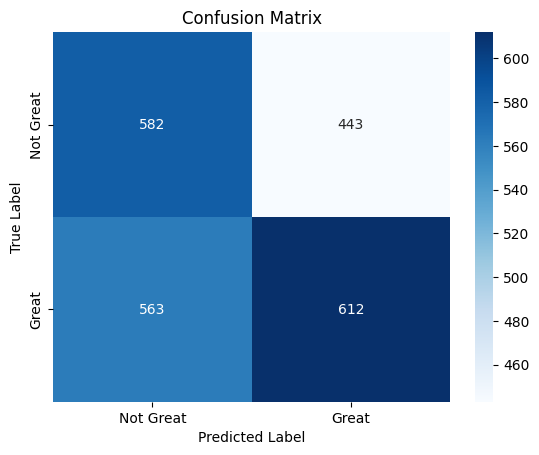

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Great', 'Great'], yticklabels=['Not Great', 'Great'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [7]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for Random Forest
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC-ROC score: {grid_search.best_score_}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best AUC-ROC score: 0.5914176566327922


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Set up the randomized search
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')

# Fit the random search
random_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)


In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [16]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


In [17]:
# Assuming rfc is your previously trained Random Forest Classifier
rf_clf = rfc  # You can reuse the model you trained

# Define other classifiers you want to combine with
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
lr_clf = LogisticRegression(random_state=42)


In [25]:
voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)], voting='soft')


In [27]:
# Fit the Voting Classifier to the training data
voting_clf.fit(X_train, y_train)


c:\Users\UGH\Desktop\Water_Quality_monitoringV2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr', LogisticRegression(random_state=42))],
                 voting='soft')

In [28]:
# Make predictions with the Voting Classifier
y_pred = voting_clf.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("AUC-ROC Score:", roc_auc)


Accuracy: 0.555
AUC-ROC Score: 0.5872788790866632
